In [1]:
from collections.abc import Iterable
import os

from adjustText import adjust_text
from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import latex
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import os
import pandas as pd
import pickle
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import pywt
import scipy.io as sio
import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tifffile import TiffFile
import tifffile

from networkx import kamada_kawai_layout

from atlas import loadmat, NPAtlas, NWBAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, get_dataset_online, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs, get_accuracy
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim, plot_accuracies, plot_visualizations_atlas, plot_visualizations_data, plot_atlas2d_super
from utils import covar_to_coord, convert_coordinates, maha_dist, run_linear_assignment

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [ ]:
#Optional import if you want to open figures in a separate window, add %matplotlib qt to top of any code box if you want figures to open in a separate window 
import PyQt6.QtCore
os.environ["QT_API"] = "pyqt6"

# Figure 1: Visualizations of NWB file contents

Figure 1 contains three ways to visualize the data stored in an NWB file. First, we train the statistical atlas on the corpus of data and generate point clouds aligned to the common atlas space. Trained atlases and aligned point clouds can be downloaded from this link https://ucsf.box.com/s/8kbdfywefcfsn4pfextrzcr25az1vmuj. Download this folder and move it into the root of this repository. You can also run the StatAtlas code provided in this repository to generate new atlases and aligned point clouds.

In [2]:
NWB_atlas = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_match_full_nosplit.pkl', ganglia='../data/neuron_ganglia.csv') #Load the fully trained Atlas

/Users/danielysprague/foco_lab/NWBelegans/Analysis/atlas.py:274: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_atlas['ganglion'].fillna('other', inplace=True)


In [3]:
def plot_data_unrolled(df_data, atlas, vRecenter = [0,0,0]): #Unrolled butterfly plot (1a)
    """df needs: x/y/zcyl, ganglion, h, theta """

    xyz = np.asarray(df_data[['X','Y','Z']])

    xyz = atlas.project_atlas_components(xyz)

    df_data['X'] = xyz[:,0]
    df_data['Y'] = xyz[:,1]
    df_data['Z'] = xyz[:,2]

    df_data = convert_coordinates(df_data, vRecenter=vRecenter)

    rgb_data = np.asarray(df_data[['R', 'G', 'B']])

    marker_size = 20

    colors_min = np.amin(rgb_data, axis=0)
    colors_max = np.amax(rgb_data, axis=0)
    color_norm = np.divide(rgb_data-colors_min, colors_max-colors_min)

    sns.set_theme(style='white')
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(6)

    ax1 = plt.subplot2grid(shape=(10,6), loc=(0,0), colspan=6, rowspan=10)
    atlas_df = atlas.get_df(vRecenter=[60, 10, -10])

    ax1.scatter(df_data['theta'], df_data['h'], c=color_norm, s=marker_size)

    ax1.axvspan(-135, -45, edgecolor=None, color='lightgrey', alpha=0.4, zorder=0, lw=0)
    ax1.axvspan(45, 135, edgecolor=None, color='lightgrey', alpha=0.4, zorder=0, lw=0)
    ax1.axvline(-180, ls='--', color='grey')
    ax1.axvline(180, ls='--', color='grey')
    ax1.set_xlabel('theta')
    ax1.set_ylabel('Distance along AP axis')
    ax1.legend(fontsize=10)

    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)


    plt.tight_layout()
    plt.show()

In [4]:
def plot_data_2d(df_data, atlas): #XZ and XY projections of the data (1b)
    plt.rcParams.update({'font.size':30})

    xyz = np.asarray(df_data[['X','Y','Z']])

    xyz = atlas.project_atlas_components(xyz)

    df_data['X'] = xyz[:,0]
    df_data['Y'] = xyz[:,1]
    df_data['Z'] = xyz[:,2]

    rgb_data = np.asarray(df_data[['R', 'G', 'B']])

    marker_size = 20

    colors_min = np.amin(rgb_data, axis=0)
    colors_max = np.amax(rgb_data, axis=0)
    color_norm = np.divide(rgb_data-colors_min, colors_max-colors_min)

    fig, axs = plt.subplots(2,1,sharex=True)

    axs[0].scatter(df_data['X'], df_data['Z'], c=color_norm, s=marker_size)
    axs[1].scatter(df_data['X'], df_data['Y'], c=color_norm, s=marker_size)
        
    axs[0].grid()
    axs[0].set_ylabel('Z')
    #axs[4].set_ylim((-15,15))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].invert_yaxis()
    #axs[0].set_xlim((-5,180))
    axs[0].autoscale_view()

    axs[1].grid()
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    #axs[5].set_ylim((-15,15))
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    #axs[1].set_xlim((-5,180))
    axs[1].autoscale_view()

    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)

    axs[0].grid(False)
    axs[1].grid(False)

    plt.show()



In [5]:
def plot_data_color(df_data, atlas): #2D projections of color space of each neuron (1b)

    rgb_data = np.asarray(df_data[['R', 'G', 'B']])

    marker_size = 20

    colors_min = np.amin(rgb_data, axis=0)
    colors_max = np.amax(rgb_data, axis=0)
    color_norm = np.divide(rgb_data-colors_min, colors_max-colors_min)

    fig, axs = plt.subplots(3,1, sharex=True)

    for ax in axs:
        #ax.set_aspect('equal')
        #ax.set_xlim(-5,35)
        #ax.set_ylim(-5,35)
        ax.set_xticks([])
        ax.set_yticks([])

    axs[0].scatter(rgb_data[:,0], rgb_data[:,1], c=color_norm, s=marker_size)
    axs[1].scatter(rgb_data[:,0], rgb_data[:,2], c=color_norm, s=marker_size)
    axs[2].scatter(rgb_data[:,1], rgb_data[:,2], c=color_norm, s=marker_size)

    axs[0].set_xlabel('red')
    axs[0].set_ylabel('green')
    axs[1].set_xlabel('red')
    axs[1].set_ylabel('blue')
    axs[2].set_xlabel('green')
    axs[2].set_ylabel('blue')

    axs[0].set_xlabel('Z-score red')
    axs[0].set_ylabel('Z-score green')
    axs[1].set_xlabel('Z-score red')
    axs[1].set_ylabel('Z-score blue')
    axs[2].set_xlabel('Z-score green')
    axs[2].set_ylabel('Z-score blue')

    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['top'].set_visible(False)
    
    plt.show()

/Users/danielysprague/foco_lab/NWBelegans/Analysis/atlas.py:274: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_atlas['ganglion'].fillna('other', inplace=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


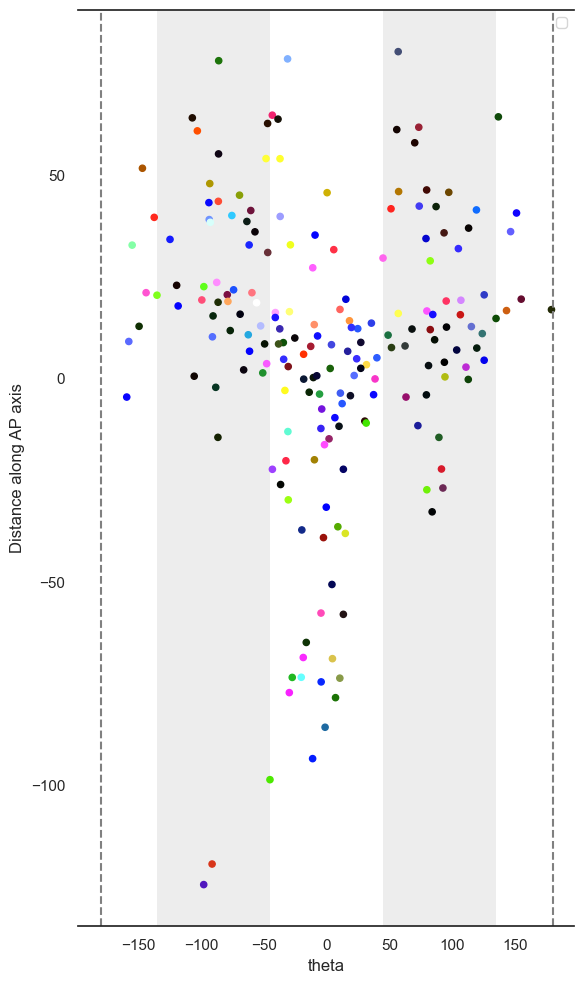

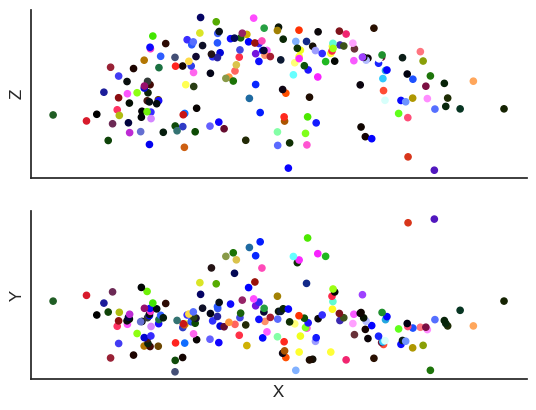

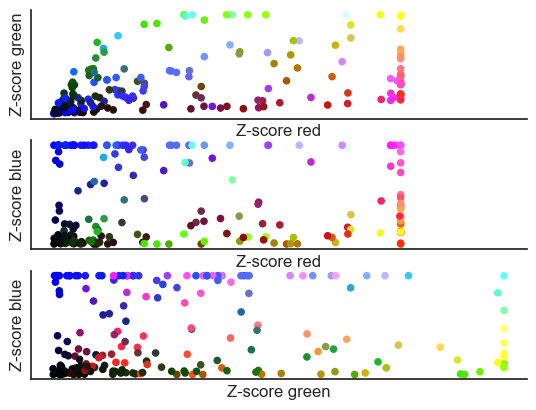

In [6]:
df_data = pd.read_csv('../data/aligned_heads/aligned_full/11_YAaLR.csv') #Load data
df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"}) #Change column names to just XYZRGB

plot_data_unrolled(df_data, NWB_atlas, vRecenter = [60, 10, -10]) #If using a different atlas, might need to play around with vRecenter a bit to get proper visualization
plot_data_2d(df_data, NWB_atlas)
plot_data_color(df_data, NWB_atlas)